In [1]:
import pandas as pd
%matplotlib inline
import tangos
import tangos.examples.mergers as mergers

import numpy as np
import h5py
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
h = 0.6776942783267969

from tangos_halo_module.halo_properties import impact_parameter, ID_to_sim_halo_snap, infall_final_n_particles, infall_final_coordinates, apocentric_distance, disruption_time, accretion_time, orbit_interpolation, infall_velocity, quenching_time, max_sSFR_time, max_mass_time 
from tangos_halo_module.path import get_file_path, get_halo_snap_num, read_file
from tangos_halo_module.halos import ID_to_tangos_halo, get_survivors, get_zombies, get_host, get_survivor_IDs, get_zombie_IDs, blockPrint, enablePrint

In [2]:
data = pd.read_csv('Data100.csv')
ids = data['ID'].to_numpy()

In [18]:
def mass_loss_interpolation(ID=0, simulation=0, status=0, tangos_halo=0, halo_id=0, snap_num=0, resolution=100):
    '''
    input params: 
        simulation: h148, h229, h242, h329: string
        status: 'Zombie', 'Survivor': string
        tangos_halo: 0 or a valid Tangos halo object
        halo_id: halo id: 0 or string or numeric
        snap_num: 0 or 4 digit simulation snapshot number: string
    output params:
        apocentric distance (distance of closest approach): the minimum distance of separation between the satellite and host CM before disruption
            [units: Virial Radius of Host]
        time of closest approach: the earliest time (before disruption) when a satellite gets closest to the host
            [units: Gyrs since start of simulation]
    '''
    from scipy.interpolate import CubicSpline
    if ID != 0:
        simulation, status, halo_id, snap_num = ID_to_sim_halo_snap(ID=ID)
    #Host
    path = get_file_path(tangos_halo=0, simulation=simulation, status='Host', halo_id='1', snap_num='4096', resolution=resolution)
    with h5py.File(path, 'r') as fh:
        t_Gyr = fh['time_|_Gyr'][:]
        hostMvir = fh['Mvir_|_Msol'][:]
        hostRvir = fh['Rvir_|_kpc'][:]
    #Satellite
    path = get_file_path(tangos_halo=tangos_halo, simulation=simulation, status=status, halo_id=halo_id, snap_num=snap_num, resolution=resolution)
    with h5py.File(path, 'r') as f:
        satMvir = f['Mvir_|_Msol'][:]
        satRvir = f['Rvir_|_kpc'][:]
        satMstar = f['M_star_|_Msol'][:]
    #Satellite Infall Time
    t_Gyr = np.array([round(t, 3) for t in t_Gyr])
    t_infall, _, _, _, _ = accretion_time(ID=ID, simulation=simulation, status=status, tangos_halo=tangos_halo, 
                              halo_id=halo_id, snap_num=snap_num, category='stars', resolution=resolution)
    Mvir_infall = satMvir[t_Gyr==t_infall]
    Mstar_infall = satMstar[t_Gyr==t_infall]
    Rvir_infall = satRvir[t_Gyr==t_infall]
    
    t = t_Gyr[(satMstar!=0) & (satMvir!=hostMvir)]
    Mvir = satMvir[(satMstar!=0) & (satMvir!=hostMvir)]/Mvir_infall
    Rvir = satRvir[(satMstar!=0) & (satMvir!=hostMvir)]/Rvir_infall
    Mstar = satMstar[(satMstar!=0) & (satMvir!=hostMvir)]/Mstar_infall
    
    dummy = [0]*3
    if len(t)==0:
        return (dummy, dummy, dummy, dummy, dummy), (dummy, dummy, dummy, dummy, dummy)
    elif len(t)>=2:
        # From: https://stackoverflow.com/questions/5283649/plot-smooth-line-with-pyplot
        # time
        t_new = np.linspace(min(t), max(t), 300)
        # Mvir
        f = CubicSpline(t, Mvir) #fxn
        Mvir_new = f(t_new)
        # Mstar
        f = CubicSpline(t, Mstar) #fxn
        Mstar_new = f(t_new)
        # Rvir
        f = CubicSpline(t, Rvir) #fxn
        Rvir_new = f(t_new)
        return (t, Mvir, Mstar, Rvir), (t_new, Mvir_new, Mstar_new, Rvir_new)
    else:
        return (t, Mvir, Mstar, Rvir), (dummy, dummy, dummy, dummy)

In [19]:
mass_loss_interpolation(ID=ids[0])

((array([ 0.767,  0.935,  1.178,  1.302,  1.545,  1.733,  2.164,  2.37 ,
          2.595,  2.925,  3.026,  3.289,  3.457,  3.733,  3.888,  4.282,
          4.319,  4.75 ,  5.181,  5.868,  6.474,  6.905,  7.04 ,  7.336,
          7.767,  8.198,  8.609,  9.06 ,  9.491,  9.922, 10.353, 10.767,
         10.784, 11.215, 11.646, 12.077, 12.151, 12.508, 12.939, 13.37 ,
         13.801]),
  array([0.07530429, 0.09338992, 0.09503119, 0.1061118 , 0.13720395,
         0.14783383, 0.18508533, 0.20145235, 0.2311435 , 0.44053847,
         0.45563571, 0.48686606, 0.47220433, 0.45195253, 0.45030492,
         0.52508748, 0.53557283, 0.65591718, 0.66413303, 0.65421189,
         0.68936378, 0.70871158, 0.71578   , 0.76153134, 0.94832133,
         1.        , 1.02655569, 1.73341617, 0.9170428 , 0.77399457,
         0.69585531, 0.64470915, 0.64272492, 0.60914963, 0.59014226,
         0.57461457, 0.57194568, 0.56001306, 0.54545403, 0.52146136,
         0.49447269]),
  array([0.04444341, 0.1515542 , 0.156939

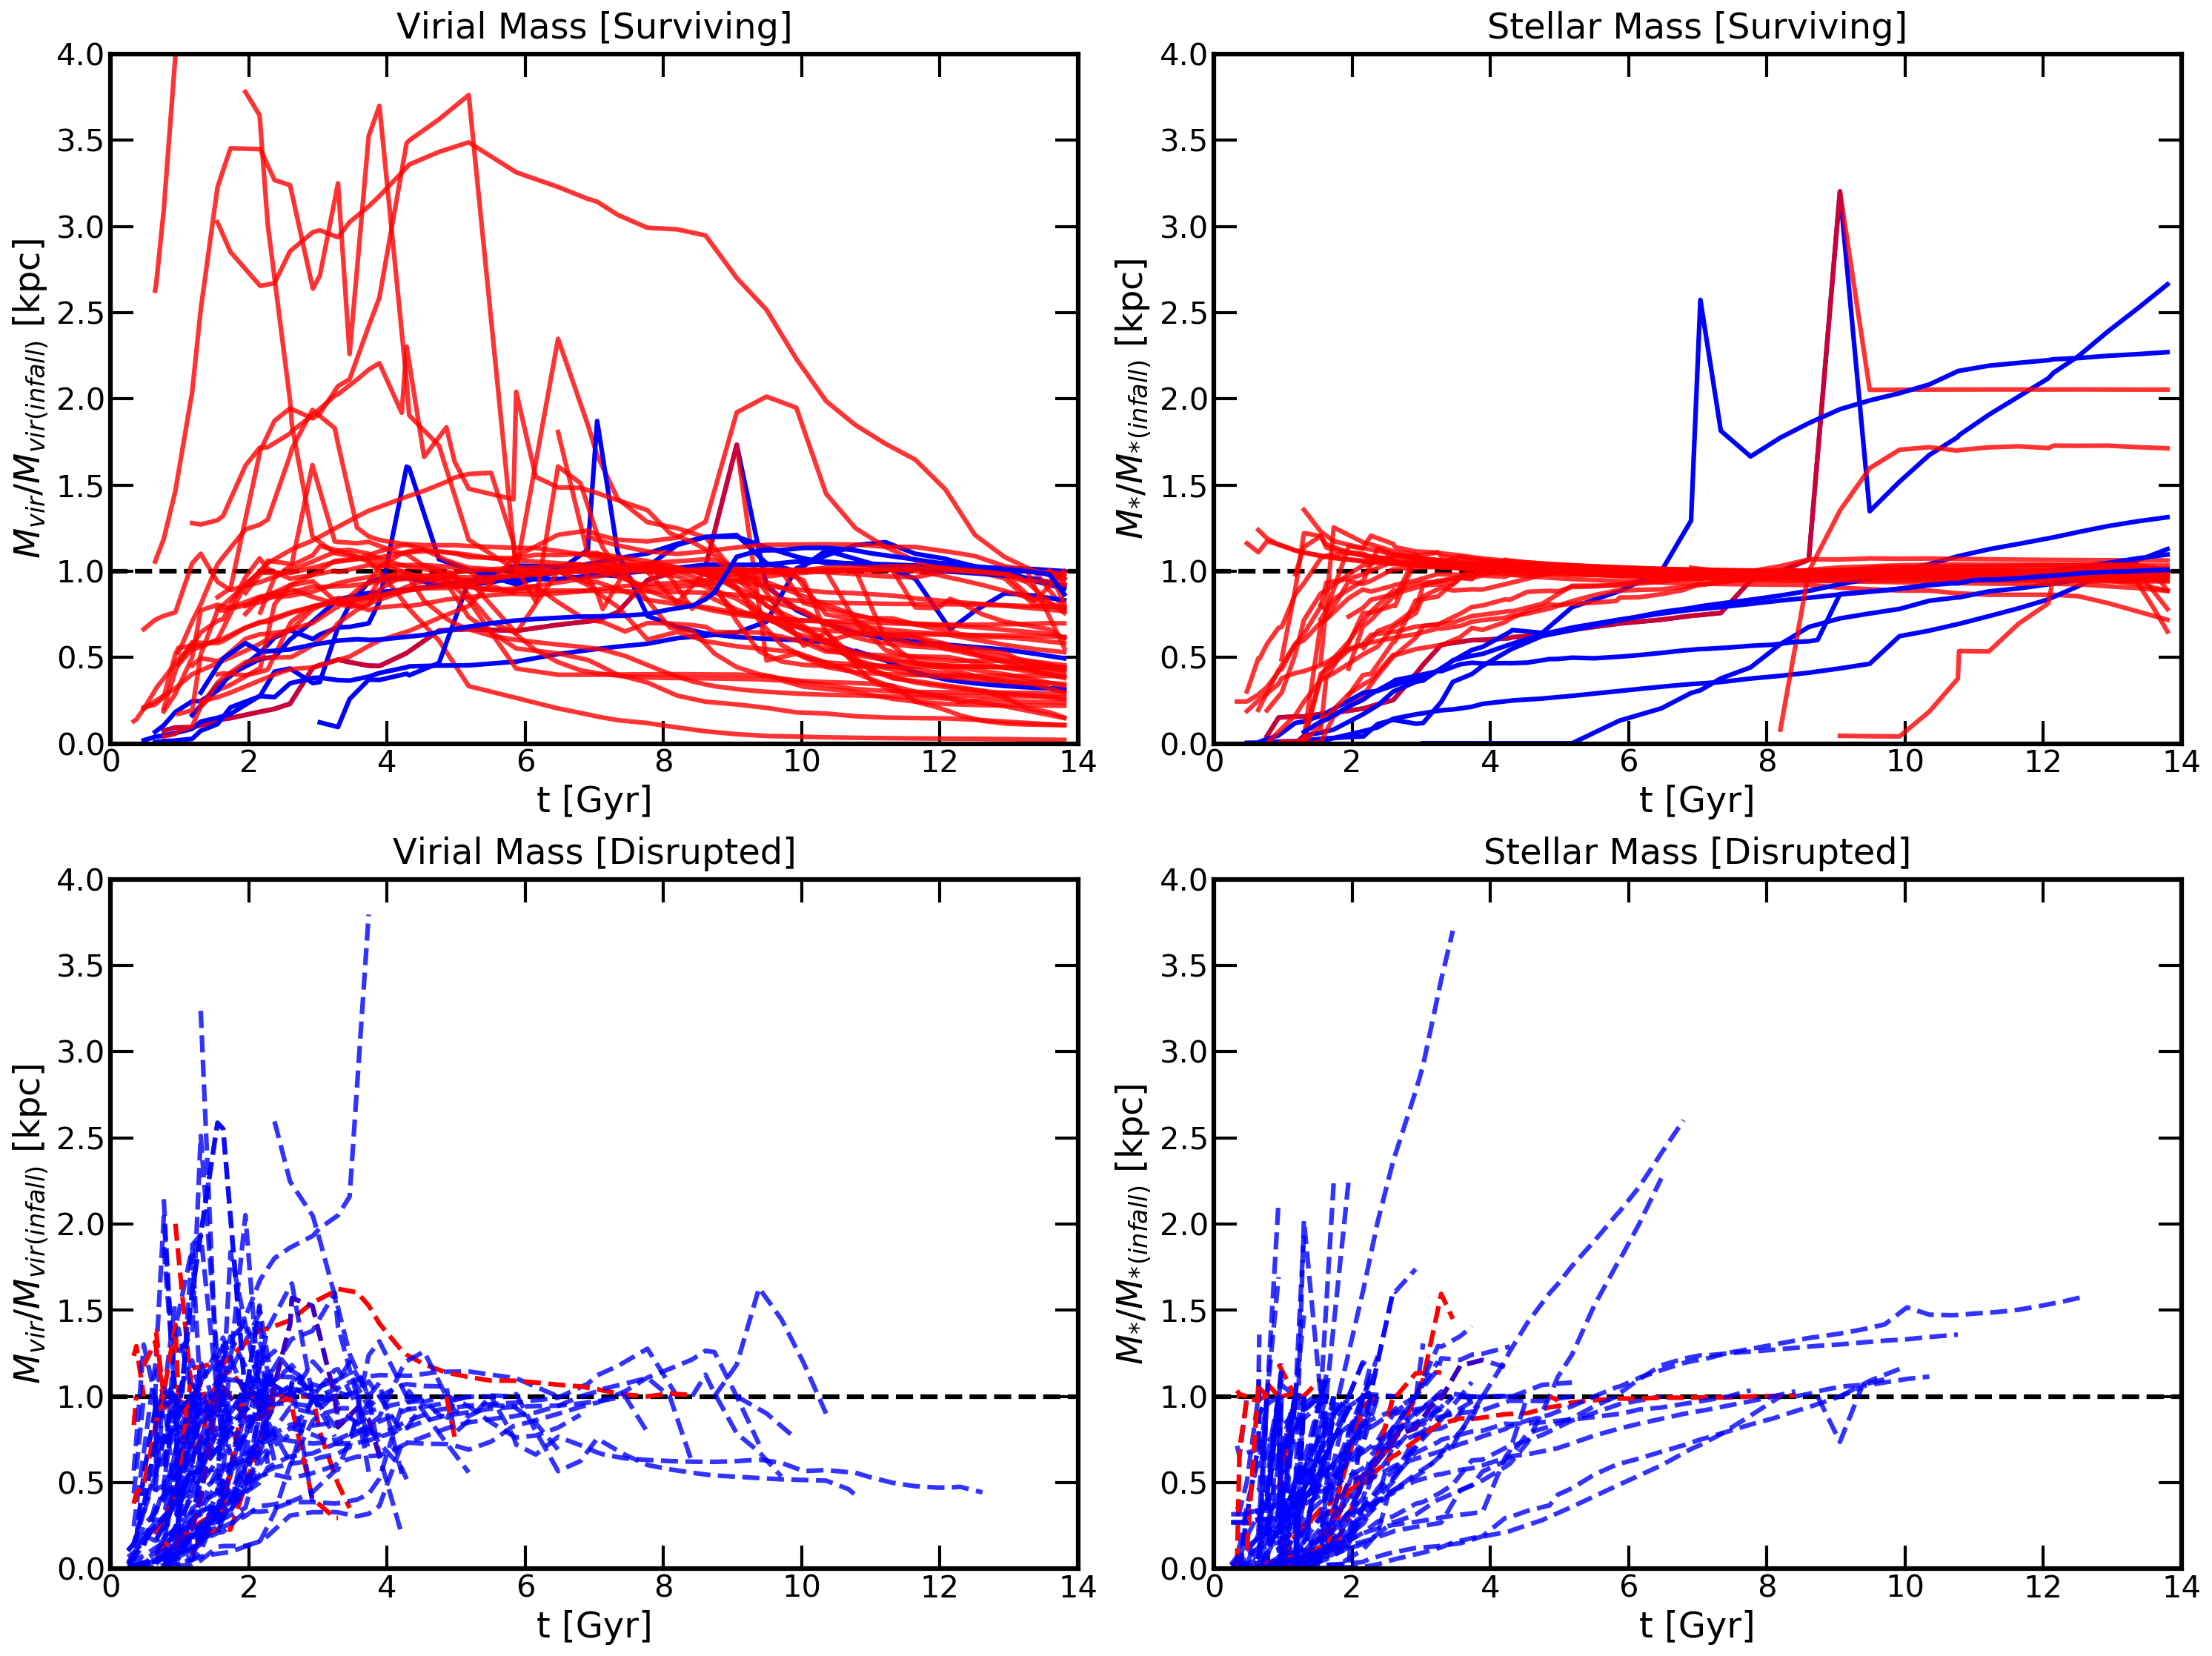

In [51]:
np.seterr(divide='ignore', invalid='ignore')
data = pd.read_csv('Data100.csv')
status = data['Status'].to_numpy()
ids = data['ID'].to_numpy()
infall_Mstar = data['infall_mass'].to_numpy()
t_infall = data['time_infall'].to_numpy()
t_disrupt = data['time_disruption'].to_numpy()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='none', sharey='none', figsize=(20, 15))
fig.set_facecolor('w')
fig.set_dpi(150)
# Increase weight of axes
plt.setp(ax1.spines.values(), linewidth=3)
plt.setp(ax2.spines.values(), linewidth=3)
plt.setp(ax3.spines.values(), linewidth=3)
plt.setp(ax4.spines.values(), linewidth=3)

ax1.axhline(1, lw=3, ls='--', c='k')
ax2.axhline(1, lw=3, ls='--', c='k')
ax3.axhline(1, lw=3, ls='--', c='k')
ax4.axhline(1, lw=3, ls='--', c='k')

for idx in ids[(status=='Survivor')]:
    (t, Mvir, Mstar, Rvir), k = mass_loss_interpolation(ID=idx, resolution=100)
    Mvir=np.array(Mvir)
    Mstar=np.array(Mstar)
    t=np.array(t)
    Mvir[Mvir>4]=np.nan
    Mstar[Mstar>4]=np.nan
    a = np.zeros(len(Mvir))
    b = np.zeros(len(Mvir))
#     for i in range(2, len(a)-2):
#         a[i] = np.average([Mvir[i-2], Mvir[i-1], Mvir[i], Mvir[i+1], Mvir[i+2]])
#         b[i] = np.average([Mstar[i-2], Mstar[i-1], Mstar[i], Mstar[i+1], Mstar[i+2]])
    t_quench = quenching_time(ID=idx, resolution=100)[0]
    if t_quench > 0:
        ax1.plot(t, Mvir, 'r-', lw=3, alpha=0.8)
        ax2.plot(t, Mstar, 'r-', lw=3, alpha=0.8)
    else:
        ax1.plot(t, Mvir, 'b-', lw=3, alpha=1)
        ax2.plot(t, Mstar, 'b-', lw=3, alpha=1)

for idx in ids[(status=='Zombie')]:
    (t, Mvir, Mstar, Rvir), k = mass_loss_interpolation(ID=idx, resolution=100)
    Mvir=np.array(Mvir)
    Mstar=np.array(Mstar)
    t=np.array(t)
    Mvir[Mvir>4]=np.nan
    Mstar[Mstar>4]=np.nan
    a = np.zeros(len(Mvir))
    b = np.zeros(len(Mvir))
#     for i in range(2, len(a)-2):
#         a[i] = np.average([Mvir[i-2], Mvir[i-1], Mvir[i], Mvir[i+1], Mvir[i+2]])
#         b[i] = np.average([Mstar[i-2], Mstar[i-1], Mstar[i], Mstar[i+1], Mstar[i+2]])
    t_quench = quenching_time(ID=idx, resolution=100)[0]
    if t_quench > 0:
        ax3.plot(t, Mvir, 'r--', lw=3, alpha=1)
        ax4.plot(t, Mstar, 'r--', lw=3, alpha=1)
    else:
        ax3.plot(t, Mvir, 'b--', lw=3, alpha=0.8)
        ax4.plot(t, Mstar, 'b--', lw=3, alpha=0.8)
    
ax1.set_xlim(0, 14)
ax1.set_ylim(0, 4)
ax1.set_xlabel('t [Gyr]', fontsize=23)
ax1.set_ylabel('$M_{vir}/{M_{vir}}_{(infall)}$ [kpc]', fontsize=23)
ax1.set_title('Virial Mass [Surviving]', fontsize=23, pad=10)
ax1.tick_params(which='major', length=15, width=2, labelsize=15)
ax1.tick_params(which='minor', length=8, width=2, labelsize=15)
ax1.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)
# ax1.set_yscale('log')

ax2.set_xlim(0, 14)
ax2.set_ylim(0, 4)
ax2.set_title('Stellar Mass [Surviving]', fontsize=23, pad=10)
ax2.set_xlabel('t [Gyr]', fontsize=23)
ax2.set_ylabel('$M_{*}/{M_{*}}_{(infall)}$ [kpc]', fontsize=23)
ax2.tick_params(which='major', length=15, width=2, labelsize=15)
ax2.tick_params(which='minor', length=8, width=2, labelsize=15)
ax2.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)

# ax2.set_yscale('log')

ax3.set_xlim(0, 14)
ax3.set_ylim(0, 4)
ax3.set_title('Virial Mass [Disrupted]', fontsize=23, pad=10)
ax3.set_xlabel('t [Gyr]', fontsize=23)
ax3.set_ylabel('$M_{vir}/{M_{vir}}_{(infall)}$ [kpc]', fontsize=23)
ax3.tick_params(which='major', length=15, width=2, labelsize=15)
ax3.tick_params(which='minor', length=8, width=2, labelsize=15)
ax3.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)

# ax1.set_yscale('log')

ax4.set_xlim(0, 14)
ax4.set_ylim(0, 4)
ax4.set_title('Stellar Mass [Disrupted]', fontsize=23, pad=10)
ax4.set_xlabel('t [Gyr]', fontsize=23)
ax4.set_ylabel('$M_{*}/{M_{*}}_{(infall)}$ [kpc]', fontsize=23)
ax4.tick_params(which='major', length=15, width=2, labelsize=15)
ax4.tick_params(which='minor', length=8, width=2, labelsize=15)
ax4.tick_params(direction='in', which='both', labelsize=20, bottom=True, top=True, left=True, right=True)

# ax2.set_yscale('log')


# # ax1.set_xscale('log')
# # ax1.legend(loc='best', fontsize=15, frameon=True)

plt.tight_layout()
